In [1]:
import numpy as np
import pandas as pdf
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
tf_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "diamonds",
    seed=41,
    shuffle=True,
    image_size=(256,256),
    batch_size=32
)

Found 14078 files belonging to 8 classes.


# Generarea setului de antrenare si setului de testare

In [3]:
epochs = 5
img_height=80
img_width=80
batch_size=20

In [4]:
def tf_split_data(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=10)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_set = ds.take(train_size)
    val_set = ds.skip(train_size).take(val_size)
    test_set = ds.skip(train_size).skip(val_size)

    return train_set, val_set, test_set

train_ds, val_ds, test_ds = tf_split_data(tf_dataset)
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [5]:
class_names = tf_dataset.class_names
print("class_names: ",class_names)
print("number of classes: ", len(class_names))

class_names:  ['cushion', 'emerald', 'heart', 'marquise', 'oval', 'pear', 'princess', 'round']
number of classes:  8


In [6]:
len(train_ds), len(test_ds)

(352, 44)

In [7]:
import tensorflow as tf
import os
#identify wrong images
def test_image_loading(image_directory):
    for subdir, dirs, files in os.walk(image_directory):
        for file in files:
            file_path = os.path.join(subdir, file)
            try:
                image = tf.io.read_file(file_path)
                image = tf.io.decode_image(image)
                #print(f"Successfully decoded: {file_path}")
            except tf.errors.InvalidArgumentError as e:
                print(f"Failed to decode: {file_path}")
            except Exception as e:
                print(f"Other error with file {file_path}: {e}")

test_image_loading("diamonds")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [9]:
labels_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 1, 0, 5, 0, 0, 2, 1, 5, 7, 0, 0, 5, 1, 3, 5, 7, 7, 7, 1, 4, 4,
       6, 2, 4, 7, 0, 2, 5, 0, 4, 1])>

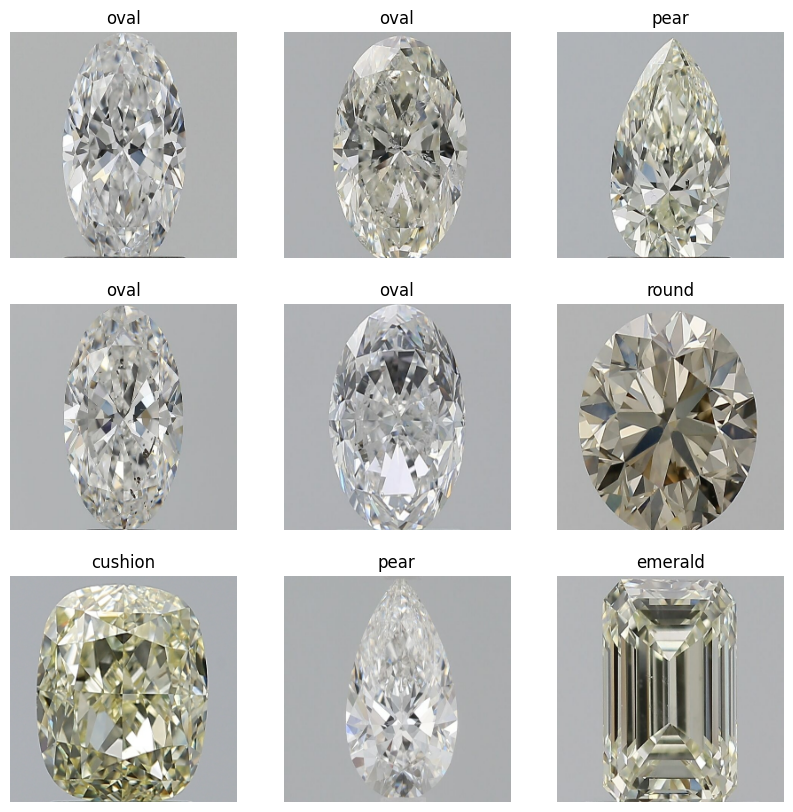

In [10]:
import matplotlib.pyplot as plt
import time
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
   # t0 = time.clock()
 #   print (time.clock() - t0, "seconds process time")

In [11]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
data_augmentation = keras.Sequential(
  [
   layers.RandomFlip("horizontal"),
   layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
]
)

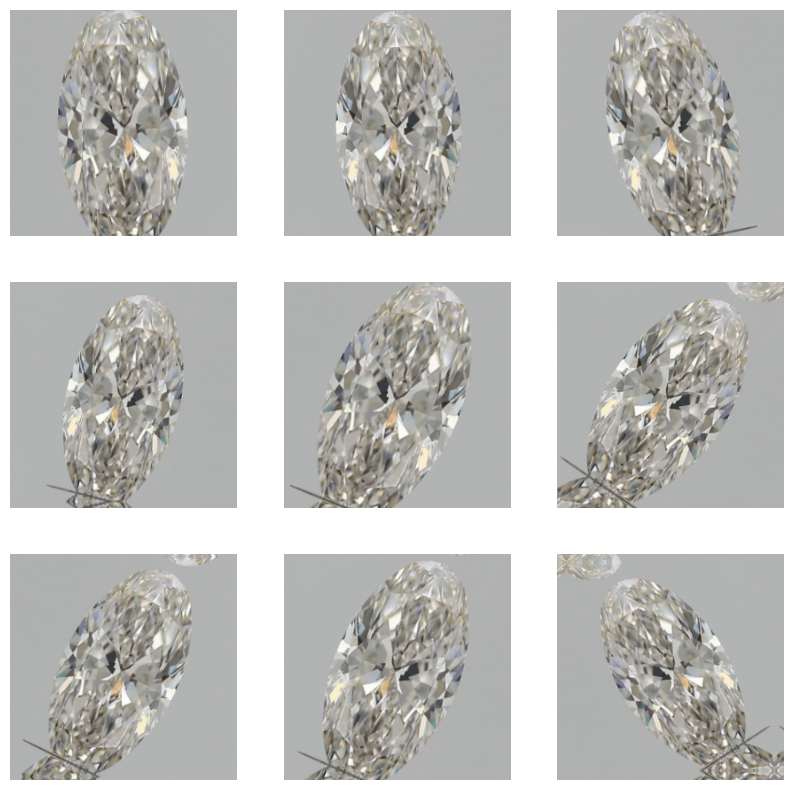

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
   for i in range(9):
      augmented_images = data_augmentation(images)
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_images[0].numpy().astype("uint8"))
      plt.axis("off")

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

num_classes = len(class_names)
input_shape = (256, 256, 3)
# Load the base ResNet50 model, pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# First, freeze all convolutional ResNet50 layers
for layer in base_model.layers:
    layer.trainable = False

model_05 = Sequential([
  base_model,
  layers.Conv2D(32, 3, padding='same', activation='relu'),
   #layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
layers.Dense(128, activation='softmax'),
])

In [15]:
from tensorflow.keras.utils import plot_model
input_shape = (None,256, 256, 3)
model_05.build(input_shape=input_shape)
#model_05.build()
plot_model(model_05, to_file='modeltr.png')
model_05.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 8, 8, 32)            │         589,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,259,744 (92.54 MB)

 Trainable params: 672,032 (2.56 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [16]:
model_05.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
#model_05.summary()

In [17]:

epochs = 5
history = model_05.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
model_05.save("resnet50.keras")

Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1523s 4s/step - accuracy: 0.9316 - loss: 0.3725 - val_accuracy: 0.9957 - val_loss: 0.0124
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1445s 4s/step - accuracy: 0.9969 - loss: 0.0148 - val_accuracy: 1.0000 - val_loss: 7.0538e-04
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1472s 4s/step - accuracy: 0.9980 - loss: 0.0101 - val_accuracy: 1.0000 - val_loss: 1.0550e-04
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1471s 4s/step - accuracy: 0.9970 - loss: 0.0137 - val_accuracy: 0.9979 - val_loss: 0.0080
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1473s 4s/step - accuracy: 0.9966 - loss: 0.0207 - val_accuracy: 1.0000 - val_loss: 1.0735e-04


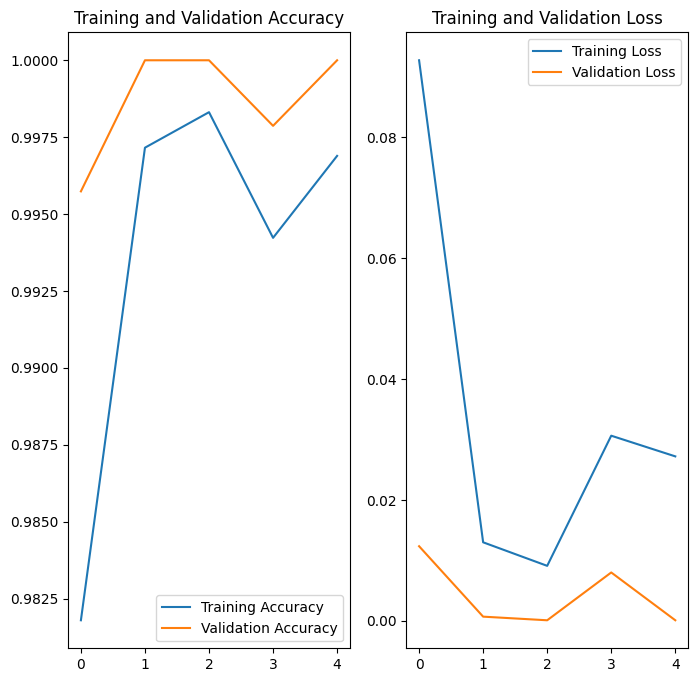

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
#model = model_05  # Get model (Sequential, Functional Model, or Model subclass)
#model_05.save('diamonds_model')

In [20]:
test_images = []
test_labels = []
for image, label in test_ds.take(-1):
  test_images.extend(image)
  test_labels.extend(label)
test_images = np.array(test_images)
test_labels = np.array(test_labels)
print(test_images.shape)
print(test_labels.shape)

(1408, 256, 256, 3)
(1408,)


In [21]:
test_loss, test_acc = model_05.evaluate(test_images,  test_labels, verbose=2)

44/44 - 164s - 4s/step - accuracy: 0.9979 - loss: 0.0205


In [22]:
print(test_acc)

0.9978693127632141


In [23]:
pred_labels1 = model_05.predict(test_ds)
pred_labels = np.argmax(pred_labels1, axis=1)

44/44 ━━━━━━━━━━━━━━━━━━━━ 169s 4s/step


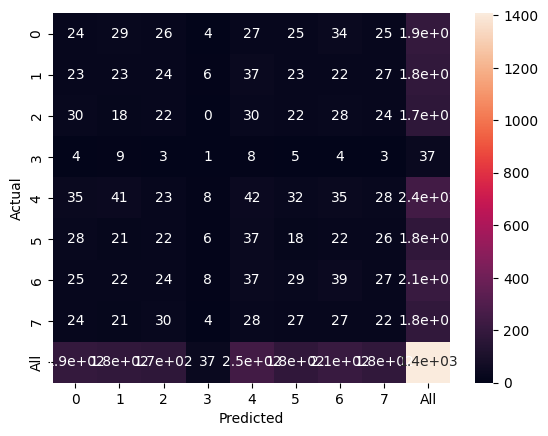

In [24]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

data = {'y_Actual':    test_labels,
        'y_Predicted': pred_labels
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)

sn.heatmap(confusion_matrix, annot=True)
plt.show()

In [25]:
# confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(test_labels, pred_labels)
print(cm)
#results(model_05)

[[24 29 26  4 27 25 34 25]
 [23 23 24  6 37 23 22 27]
 [30 18 22  0 30 22 28 24]
 [ 4  9  3  1  8  5  4  3]
 [35 41 23  8 42 32 35 28]
 [28 21 22  6 37 18 22 26]
 [25 22 24  8 37 29 39 27]
 [24 21 30  4 28 27 27 22]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

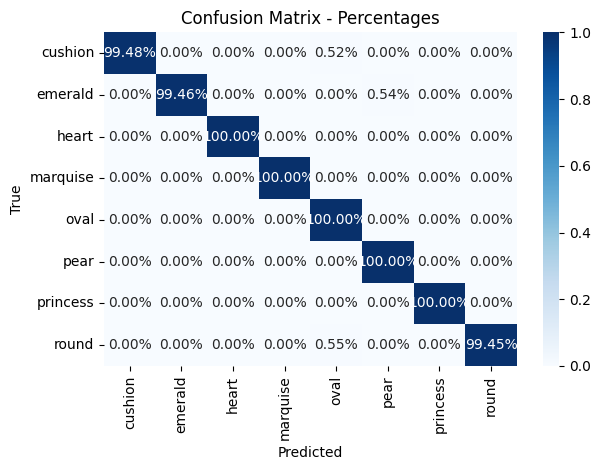

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def get_true_labels_and_predictions(model, dataset):
    true_labels = []
    predictions = []
    for batch in dataset:  
        images, labels = batch
        preds = model.predict(images)
        true_labels.extend(labels.numpy())
        predictions.extend(np.argmax(preds, axis=1))
    return true_labels, predictions

true_labels, predicted_labels = get_true_labels_and_predictions(model_05, test_ds)

cm = confusion_matrix(true_labels, predicted_labels)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#plt.subplot(1, 2, 2) 
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels, target_names=class_names))

sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Percentages')

plt.tight_layout() 
plt.show()

In [27]:
acc=(cm[0,0]+cm[1,1])/(cm[0,0]+cm[1,1]+cm[0,1]+cm[1,0])
print(acc)

1.0


In [28]:
from tensorflow.keras.models import save_model, load_model
import pickle
save_model(model_05, 'diamonds_tr_5ep.keras')